In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler
from category_encoders.leave_one_out import LeaveOneOutEncoder
from category_encoders.cat_boost import  CatBoostEncoder
from category_encoders.binary import BinaryEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from xgboost import XGBClassifier
from prettytable import PrettyTable

%matplotlib inline

In [2]:
df = pd.read_pickle('soft_impute.pickle')

In [3]:
df.head()

,Var6,Var7,Var13,Var21,Var24,Var25,Var28,Var35,Var38,Var44,...,nan_Var218,nan_Var219,nan_Var221,nan_Var223,nan_Var226,nan_Var227,nan_Var228,Appetency,Churn,Upselling
0,1526.000000,7.0,184.0,464.000000,14.000000,128.0,166.56,0.0,3570.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,-1
1,525.000000,0.0,0.0,168.000000,2.000000,24.0,353.52,0.0,4764966.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,1,-1
2,5236.000000,7.0,904.0,1212.000000,26.000000,816.0,220.08,0.0,5883894.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,-1
3,69.125019,0.0,0.0,13.556917,0.361196,0.0,22.08,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,-1
4,1029.000000,7.0,3216.0,64.000000,4.000000,64.0,200.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,-1


In [4]:
# convert target values to binary
df_model = df.copy()

targets = ['Appetency', 'Churn', 'Upselling']

for col in targets:
    df_model[col] = df_model[col].apply(lambda x: 1 if x==1 else 0)
df_model[['Appetency', 'Churn', 'Upselling']].head()

,Appetency,Churn,Upselling
0,0,0,0
1,0,1,0
2,0,0,0
3,0,0,0
4,0,0,0


In [5]:
# Separate predictors and response
X = df_model.drop(columns=targets)

y_churn = df_model.Churn
y_appetency = df_model.Appetency
y_upselling = df_model.Upselling

X.shape, y_churn.shape

((50000, 120), (50000,))

 Encoding Categorical Data

LeaveOneOutEncoder: Leave one out coding for categorical features.
 This is very similar to target encoding but excludes the current row’s target when calculating the mean target 
 for a level to reduce the effect of outliers.

CatBoost: https://arxiv.org/abs/1706.09516
Beware, the training data have to be randomly permutated. E.g.:

In [6]:
# Random permutation perm = np.random.permutation(len(X)) 
#X = X.iloc[perm].reset_index(drop=True) 
#y = y.iloc[perm].reset_index(drop=True)

numerical_ix = X.select_dtypes(include=['int64', 'float64']).columns
categorical_ix = X.select_dtypes(include=['category', 'bool']).columns

print('Numerical features :', len(numerical_ix)) 
print('Categorical features :', len(categorical_ix))

Numerical features : 98
Categorical features : 22


In [7]:
# split datasets into X_train and y_train
X_train_churn, X_test_churn, y_train_churn, y_test_churn = train_test_split(X, y_churn, test_size = 0.2,random_state=42 )
X_train_appetency, X_test_appetency, y_train_appetency, y_test_appetency = train_test_split(X, y_appetency, test_size = 0.2,random_state=42 )
X_train_upselling, X_test_upselling, y_train_upselling, y_test_upselling = train_test_split(X, y_upselling, test_size = 0.2,random_state=42 )

In [8]:
# split the training data into train and validation sets. 
X_train_churn, X_val_churn, y_train_churn, y_val_churn = train_test_split(X_train_churn, y_train_churn, test_size = 0.2,random_state=42, stratify=y_train_churn)
X_train_appetency, X_val_appetency, y_train_appetency, y_val_appetency = train_test_split(X_train_appetency, y_train_appetency, test_size = 0.2,random_state=42, stratify=y_train_appetency)
X_train_upselling, X_val_upselling, y_train_upselling, y_val_upselling = train_test_split(X_train_upselling, y_train_upselling, test_size = 0.2,random_state=42, stratify=y_train_upselling)

We employ three different baseline models owing to the different structural differences between them
1. Logisitic Regression with Lasso Regularization
2. Decision Tree
3. Gaussian Naive Bayes

### Logistic Regression

In [9]:
#Using logisitc Regression
# transform using encoder and standard scaler-----> pipeline required

over = SMOTE()

# create a transformer for the categorical values
categorical_transformer = Pipeline(steps=[
    ('encode_leaveoneout', LeaveOneOutEncoder(sigma=0.05))])

# create a transformed for the numerical values
# standardize the numerical data
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_ix),
        ('cat', categorical_transformer, categorical_ix)
    ])

#Lasso Regularization
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('o', over),
                      ('classifier', LogisticRegression(penalty='l1',solver='saga'))])

clf.fit(X_train_churn, y_train_churn)

/home/rovina/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Var6', 'Var7', 'Var13', 'Var21', 'Var24', 'Var25', 'Var28', 'Var35',
       'Var38', 'Var44', 'Var57', 'Var65', 'Var73', 'Var74', 'Var76', 'Var78',
       'Var81', 'Var83', 'Var85', 'Var109', 'Var112', 'Var113', 'Var119',
       'Var123', 'Var125', 'Var126', 'Var132', 'Var...
                                                  Pipeline(steps=[('encode_leaveoneout',
                                                                   LeaveOneOutEncoder(sigma=0.05))]),
                                                  Index(['Var192', 'Var193', 'Var195', 'Var196', 'Var197', 'Var203', 'Var204',
       'Var205', 'Var206', 'Var207', 'Var208', 'Var210', 'Var211', 'Var212',
       'Var216'

In [10]:
y_pred_train_churn = clf.predict_proba(X_train_churn)[:,-1]
y_pred_val_lr_churn = clf.predict_proba(X_val_churn)[:,-1]
fpr_lr_churn, tpr_lr_churn, _ = roc_curve(y_val_churn, y_pred_val_lr_churn)
y_predict_val_churn = clf.predict(X_val_churn)

print("The ROC score for training set is:",roc_auc_score(y_train_churn, y_pred_train_churn))
print("The ROC score for validation set is:",roc_auc_score(y_val_churn, y_pred_val_lr_churn))
print("Confusion matrix for validation set:\n",confusion_matrix(y_val_churn, y_predict_val_churn))

The ROC score for training set is: 0.7101473143700087
The ROC score for validation set is: 0.6994556255993282
Confusion matrix for validation set:
 [[4539 2866]
 [ 197  398]]


In [11]:
clf.fit(X_train_appetency, y_train_appetency)

y_pred_train_appetency = clf.predict_proba(X_train_appetency)[:,-1]
y_pred_val_lr_appetency = clf.predict_proba(X_val_appetency)[:,-1]
fpr_lr_appetency, tpr_lr_appetency, _ = roc_curve(y_val_churn, y_pred_val_lr_appetency)
y_predict_val_appetency = clf.predict(X_val_appetency)

print("The ROC score for training set is:",roc_auc_score(y_train_appetency, y_pred_train_appetency))
print("The ROC score for validation set is:",roc_auc_score(y_val_appetency, y_pred_val_lr_appetency))
print("Confusion matrix for validation set:\n",confusion_matrix(y_val_appetency, y_predict_val_appetency))

/home/rovina/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


The ROC score for training set is: 0.7769701170295029
The ROC score for validation set is: 0.7620922320507475
Confusion matrix for validation set:
 [[5544 2311]
 [  41  104]]


In [12]:
clf.fit(X_train_upselling, y_train_upselling)
y_pred_train_upselling = clf.predict_proba(X_train_upselling)[:,-1]
y_pred_val_lr_upselling = clf.predict_proba(X_val_upselling)[:,-1]
fpr_lr_upselling, tpr_lr_upselling, _ = roc_curve(y_val_churn, y_pred_val_lr_upselling)
y_predict_val_upselling = clf.predict(X_val_upselling)

print("The ROC score for training set is:",roc_auc_score(y_train_upselling, y_pred_train_upselling))
print("The ROC score for validation set is:",roc_auc_score(y_val_upselling, y_pred_val_lr_upselling))
print("Confusion matrix for validation set:\n",confusion_matrix(y_val_upselling, y_predict_val_upselling))

/home/rovina/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


The ROC score for training set is: 0.7503059050285696
The ROC score for validation set is: 0.7205041683712561
Confusion matrix for validation set:
 [[5011 2406]
 [ 219  364]]


### Decision Tree

In [13]:
# Using a tree based model: DecsionTreeClassifier
# used Variancethreshold: keep all features with non-zero variance, and remove the features that have the same value 
# in all samples.


categorical_transformer = Pipeline(steps=[
    ('encode_leaveoneout', LeaveOneOutEncoder(sigma=0.05))])


numeric_transformer = Pipeline(steps=[
    ('var_threshold', VarianceThreshold(threshold=0))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_ix),
        ('cat', categorical_transformer, categorical_ix)
    ])


clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('o', over),
                      ('classifier', DecisionTreeClassifier(max_depth=1))])

In [14]:
clf.fit(X_train_churn, y_train_churn)

y_pred_train_churn = clf.predict_proba(X_train_churn)[:,-1]
y_pred_val_dtree_churn = clf.predict_proba(X_val_churn)[:,-1]
fpr_dtree_churn, tpr_dtree_churn, _ = roc_curve(y_val_churn, y_pred_val_dtree_churn)
y_predict_val_churn = clf.predict(X_val_churn)

print("The ROC score for training set is:",roc_auc_score(y_train_churn, y_pred_train_churn))
print("The ROC score for validation set is:",roc_auc_score(y_val_churn, y_pred_val_dtree_churn))
print("Confusion matrix for validation set:\n",confusion_matrix(y_val_churn, y_predict_val_churn))

The ROC score for training set is: 0.5775805542718337
The ROC score for validation set is: 0.5834281855888879
Confusion matrix for validation set:
 [[5467 1938]
 [ 340  255]]


In [15]:
clf.fit(X_train_appetency, y_train_appetency)

y_pred_train_appetency = clf.predict_proba(X_train_appetency)[:,-1]
y_pred_val_dtree_appetency = clf.predict_proba(X_val_appetency)[:,-1]
fpr_dtree_appetency, tpr_dtree_appetency, _ = roc_curve(y_val_churn, y_pred_val_dtree_appetency)
y_predict_val_appetency = clf.predict(X_val_appetency)

print("The ROC score for training set is:",roc_auc_score(y_train_appetency, y_pred_train_appetency))
print("The ROC score for validation set is:",roc_auc_score(y_val_appetency, y_pred_val_dtree_appetency))
print("Confusion matrix for validation set:\n",confusion_matrix(y_val_appetency, y_predict_val_appetency))

The ROC score for training set is: 0.6794433472767962
The ROC score for validation set is: 0.681893808029149
Confusion matrix for validation set:
 [[3941 3914]
 [  20  125]]


In [16]:
clf.fit(X_train_upselling, y_train_upselling)

y_pred_train_upselling = clf.predict_proba(X_train_upselling)[:,-1]
y_pred_val_dtree_upselling = clf.predict_proba(X_val_upselling)[:,-1]
fpr_dtree_upselling, tpr_dtree_upselling, _ = roc_curve(y_val_churn, y_pred_val_dtree_upselling)
y_predict_val_upselling = clf.predict(X_val_upselling)

print("The ROC score for training set is:",roc_auc_score(y_train_upselling, y_pred_train_upselling))
print("The ROC score for validation set is:",roc_auc_score(y_val_upselling, y_pred_val_dtree_upselling))
print("Confusion matrix for validation set:\n",confusion_matrix(y_val_upselling, y_predict_val_upselling))

The ROC score for training set is: 0.7370004444223379
The ROC score for validation set is: 0.7277632327199741
Confusion matrix for validation set:
 [[7208  209]
 [ 301  282]]


### Gaussian Naive Bayes

In [17]:
# Using Naive Bayes: GaussianNB

# create a transformer for the categorical values
categorical_transformer = Pipeline(steps=[
    ('encode_leaveoneout', LeaveOneOutEncoder(sigma=0.05))])

# create a transformed for the numerical values
# standardize the numerical data
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

#('Kbins', KBinsDiscretizer(n_bins=i, encode='ordinal', strategy='quantile')),
#can use SoftImpute(), SimpleImpute() here

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_ix),
        ('cat', categorical_transformer, categorical_ix)
    ])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', GaussianNB())],
              verbose=False)

In [18]:
clf.fit(X_train_churn, y_train_churn)

y_pred_train_churn = clf.predict_proba(X_train_churn)[:,-1]
y_pred_val_gnb_churn = clf.predict_proba(X_val_churn)[:,-1]
fpr_gnb_churn, tpr_gnb_churn, _ = roc_curve(y_val_churn, y_pred_val_gnb_churn)
y_predict_val_churn = clf.predict(X_val_churn)

print("The ROC score for training set is:",roc_auc_score(y_train_churn, y_pred_train_churn))
print("The ROC score for validation set is:",roc_auc_score(y_val_churn, y_pred_val_gnb_churn))
print("Confusion matrix for validation set:\n",confusion_matrix(y_val_churn, y_predict_val_churn))

The ROC score for training set is: 0.6636842460665812
The ROC score for validation set is: 0.6560175670538303
Confusion matrix for validation set:
 [[2464 4941]
 [ 115  480]]


In [19]:
clf.fit(X_train_appetency, y_train_appetency)

y_pred_train_appetency = clf.predict_proba(X_train_appetency)[:,-1]
y_pred_val_gnb_appetency = clf.predict_proba(X_val_appetency)[:,-1]
fpr_gnb_appetency, tpr_gnb_appetency, _ = roc_curve(y_val_churn, y_pred_val_gnb_appetency)
y_predict_val_appetency = clf.predict(X_val_appetency)

print("The ROC score for training set is:",roc_auc_score(y_train_appetency, y_pred_train_appetency))
print("The ROC score for validation set is:",roc_auc_score(y_val_appetency, y_pred_val_gnb_appetency))
print("Confusion matrix for validation set:\n",confusion_matrix(y_val_appetency, y_predict_val_appetency))

The ROC score for training set is: 0.7426669080508908
The ROC score for validation set is: 0.6974538510502863
Confusion matrix for validation set:
 [[6880  975]
 [ 105   40]]


In [20]:
clf.fit(X_train_upselling, y_train_upselling)
y_pred_train_upselling = clf.predict_proba(X_train_upselling)[:,-1]
y_pred_val_gnb_upselling = clf.predict_proba(X_val_upselling)[:,-1]
fpr_gnb_upselling, tpr_gnb_upselling, _ = roc_curve(y_val_churn, y_pred_val_gnb_upselling)
y_predict_val_upselling = clf.predict(X_val_upselling)

print("The ROC score for training set is:",roc_auc_score(y_train_upselling, y_pred_train_upselling))
print("The ROC score for validation set is:",roc_auc_score(y_val_upselling, y_pred_val_gnb_upselling))
print("Confusion matrix for validation set:\n",confusion_matrix(y_val_upselling, y_predict_val_upselling))

The ROC score for training set is: 0.7054940823314189
The ROC score for validation set is: 0.6702812439366149
Confusion matrix for validation set:
 [[2527 4890]
 [  70  513]]


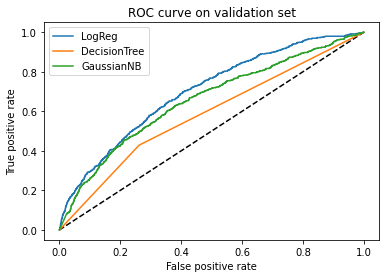

In [21]:
# plot
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr_churn, tpr_lr_churn, label='LogReg')
plt.plot(fpr_dtree_churn, tpr_dtree_churn, label='DecisionTree')
plt.plot(fpr_gnb_churn, tpr_gnb_churn, label='GaussianNB')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve on validation set')
plt.legend(loc='best')
plt.show()

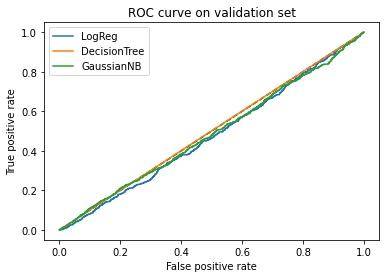

In [22]:
# plot
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr_appetency, tpr_lr_appetency, label='LogReg')
plt.plot(fpr_dtree_appetency, tpr_dtree_appetency, label='DecisionTree')
plt.plot(fpr_gnb_appetency, tpr_gnb_appetency, label='GaussianNB')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve on validation set')
plt.legend(loc='best')
plt.show()

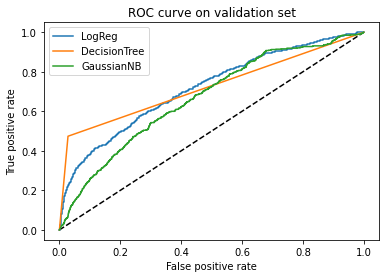

In [23]:
# plot
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr_upselling, tpr_lr_upselling, label='LogReg')
plt.plot(fpr_dtree_upselling, tpr_dtree_upselling, label='DecisionTree')
plt.plot(fpr_gnb_upselling, tpr_gnb_upselling, label='GaussianNB')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve on validation set')
plt.legend(loc='best')
plt.show()

In [26]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model","Data","AUC score","Average AUC score"]
x.add_row(["LogReg with Lasso","Appetency",0.761," "])
x.add_row(["LogReg with Lasso","Churn",0.699," "])
x.add_row(["LogReg with Lasso","Upsell",0.721,0.727])
x.add_row(["Decision Tree","Appetency",0.681," "])
x.add_row(["Decision Tree","Churn",0.583," "])
x.add_row(["Decision Tree","Upsell",0.727,0.763])
x.add_row(["Gaussian NB","Appetency",0.697," "])
x.add_row(["Gaussian NB","Churn",0.656," "])
x.add_row(["Gaussian NB","Upsell",0.671,0.674])

print(x)

+-------------------+-----------+-----------+-------------------+
|       Model       |    Data   | AUC score | Average AUC score |
+-------------------+-----------+-----------+-------------------+
| LogReg with Lasso | Appetency |   0.761   |                   |
| LogReg with Lasso |   Churn   |   0.699   |                   |
| LogReg with Lasso |   Upsell  |   0.721   |       0.727       |
|   Decision Tree   | Appetency |   0.681   |                   |
|   Decision Tree   |   Churn   |   0.583   |                   |
|   Decision Tree   |   Upsell  |   0.727   |       0.763       |
|    Gaussian NB    | Appetency |   0.697   |                   |
|    Gaussian NB    |   Churn   |   0.656   |                   |
|    Gaussian NB    |   Upsell  |   0.671   |       0.674       |
+-------------------+-----------+-----------+-------------------+


Decision Trees are better with handling the classification problem at hand and the Lasso Regualrization also helps with the score for Logisitic Regression. The simplest of these is the Gaussian Naive Bayes and this is the model that our ensemble models with all the hyper-tuning must beat.